In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
      if obj.find('name').text == "person":

        return 1 + adjust_label

    elif obj.find('name').text == "conatainer":

        return 2 + adjust_label
    
    elif obj.find('name').text == "forklift":

        return 3 + adjust_label

    elif obj.find('name').text == "ship":

        return 4 + adjust_label
    elif obj.find('name').text == "truck":

        return 5 + adjust_label

    return 0 + adjust_label

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [ ]:
imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))

In [ ]:
labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/kaggle/input/face-mask-detection/images/", file_image)
        label_path = os.path.join("/kaggle/input/face-mask-detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

# Model

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Train Model

In [ ]:

num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


tensor(72.1872, device='cuda:0', grad_fn=<AddBackward0>)
tensor(40.7142, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.1150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.2739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.3543, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.8011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.0986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.7392, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.3566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.4939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.0684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.7488, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.6532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.7847, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.2742, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.9851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.2775, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.1273, device='cuda:0'

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[184.7089,  98.9198, 227.5670, 145.4256]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9998], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[316.9235,  32.5041, 354.5669,  71.4930],
          [ 19.7582,  71.3666,  43.8890,  93.5202],
          [191.6475,  65.0783, 216.9887,  93.4339],
          [222.8352,  36.7085, 260.8708,  75.6303],
          [140.7300,  74.2098, 174.0340, 113.5757],
          [297.2307,  58.2512, 314.6167,  82.2568],
          [366.1462,  70.9785, 394.2121,  97.6998]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9997, 0.9994, 0.9992, 0.9992, 0.9985, 0.9667, 0.6881],
         device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 70.7904,  41.3814, 101.2524,  70.1367],
          [153.6275,  48.4090, 176.6959,  75.0189],
          [237.2120,  33.6722, 264.5823,  

# Function to plot image

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


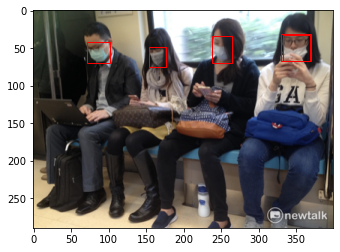

Target


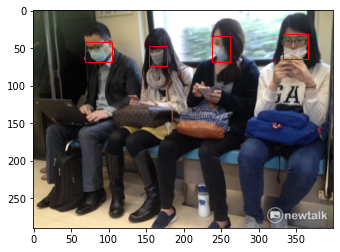

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

# Load Model

In [ ]:
pred2 = model2(imgs)

Predict with loaded model


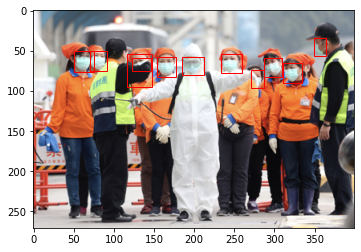

In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])